<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020/blob/main/1D_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How to Develop a 1D Generative Adversarial Network From Scratch in Keras**

Code from:
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

In [60]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense, Flatten
from matplotlib import pyplot

import numpy as np


In [61]:

# length of the input vector
#vec_length=16


define the standalone discriminator model

In [62]:

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
  model = Sequential()
  model.add(Flatten(input_dim=n_inputs))
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform')) 
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model


define the standalone generator model

In [63]:

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) 

	model.add(Dense(n_outputs, activation='linear'))
	return model


define the combined generator and discriminator model, for updating the generator

In [64]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model


generate n real samples with class labels

In [65]:

# generate n real samples with class labels
def generate_real_samples(n):

  '''
  X = np.zeros(shape=(n,2,vec_length))
  for i in range(0,n):
    x1 = np.linspace(0,1,vec_length) + 0.1*randn(vec_length)
    x2 = 2.*(np.random.randint(2, size=1)-0.5)*x1 + 0.1*randn(vec_length)
    X[i] = np.vstack((x1,x2))
    
  #print(X.shape)
  y = ones((n, 1))  
  return X, y
  '''

  # generate inputs in [-0.5, 0.5]
  X1 = rand(n) - 0.5
  # generate outputs X^2
  X2 = X1 * X1
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y




generate points in latent space as input for the generator

In [66]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input


use the generator to generate n fake examples, with class labels

In [67]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)   #.reshape(n, 2, vec_length)
	# create class labels
	y = zeros((n, 1))
	return X, y


evaluate the discriminator and plot real and fake points

In [68]:

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
  # prepare real samples
  x_real, y_real = generate_real_samples(n)
  # evaluate discriminator on real examples
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)

  # evaluate discriminator on fake examples
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print(epoch, acc_real, acc_fake)
  # scatter plot real and fake data points
  pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
  pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
  pyplot.show()


train the generator and discriminator

In [69]:

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=200):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)


Run all

199 0.5099999904632568 0.800000011920929


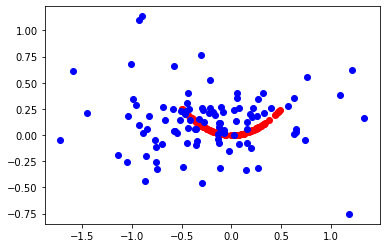

399 0.7099999785423279 0.20000000298023224


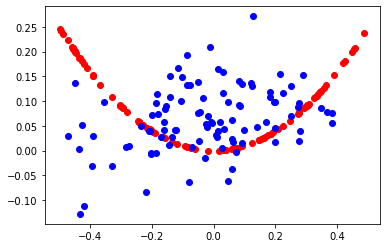

599 1.0 0.009999999776482582


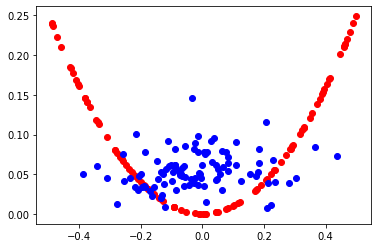

799 1.0 0.05999999865889549


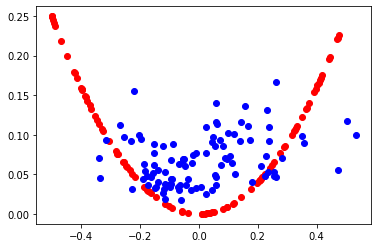

999 0.6000000238418579 0.6700000166893005


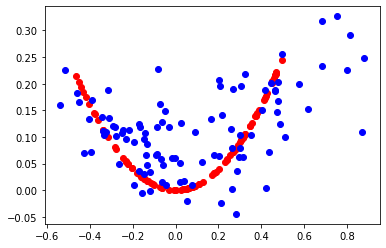

1199 0.699999988079071 0.5600000023841858


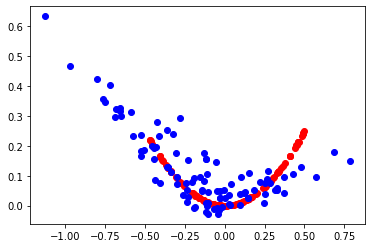

1399 0.8399999737739563 0.4300000071525574


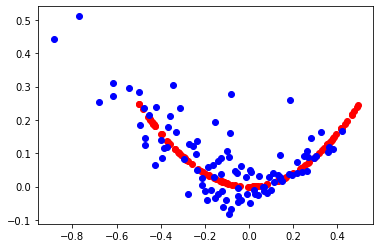

1599 0.7900000214576721 0.4300000071525574


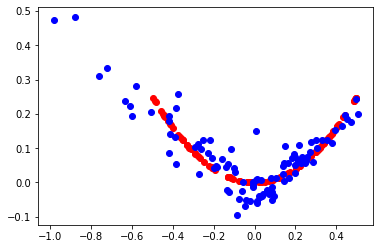

1799 0.6899999976158142 0.5699999928474426


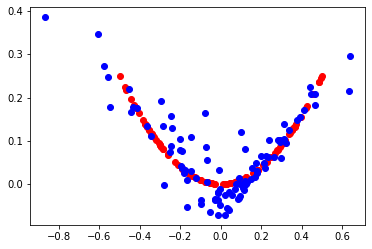

1999 0.6200000047683716 0.6000000238418579


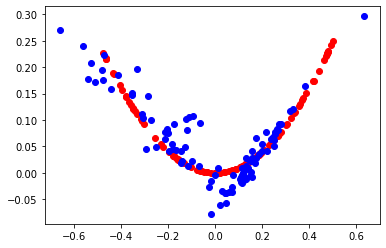

2199 0.6700000166893005 0.44999998807907104


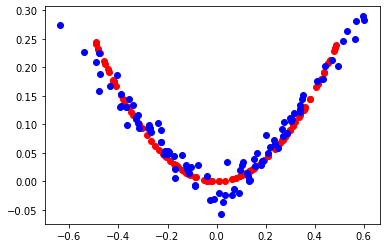

2399 0.6100000143051147 0.49000000953674316


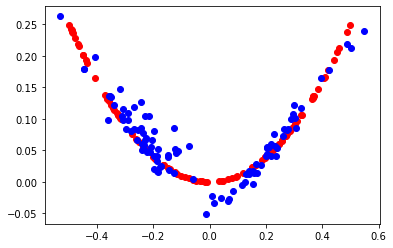

2599 0.30000001192092896 0.7900000214576721


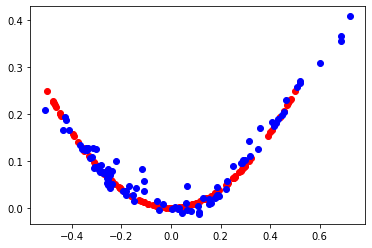

2799 0.28999999165534973 0.6899999976158142


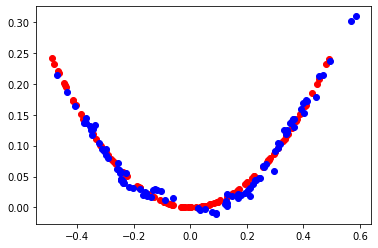

2999 0.23000000417232513 0.699999988079071


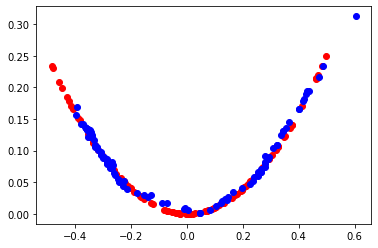

3199 0.25 0.6800000071525574


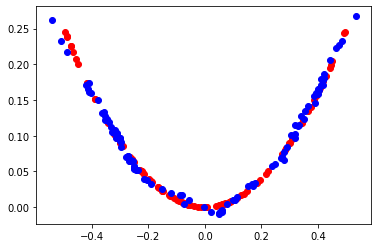

3399 0.3499999940395355 0.5199999809265137


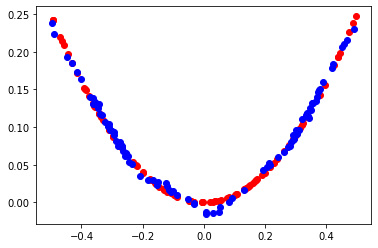

3599 0.3799999952316284 0.6700000166893005


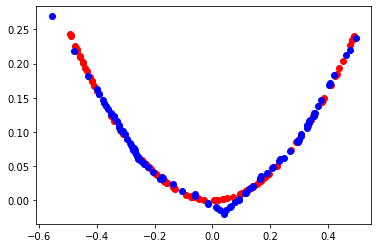

3799 0.23999999463558197 0.8899999856948853


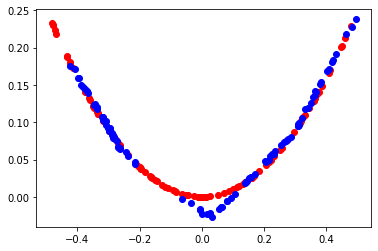

3999 0.17000000178813934 0.8199999928474426


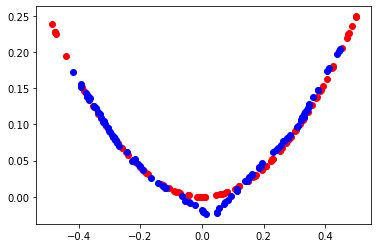

4199 0.36000001430511475 0.8399999737739563


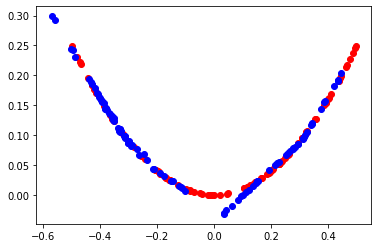

4399 0.7799999713897705 0.38999998569488525


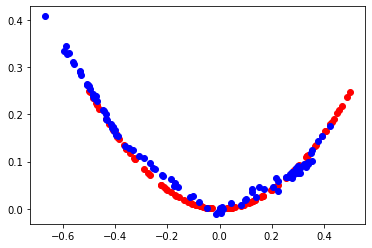

4599 0.2800000011920929 0.8999999761581421


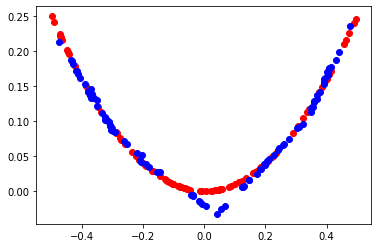

4799 0.47999998927116394 0.6299999952316284


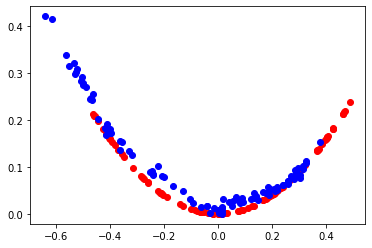

4999 0.4300000071525574 0.699999988079071


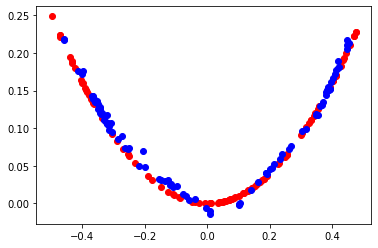

5199 0.5899999737739563 0.4399999976158142


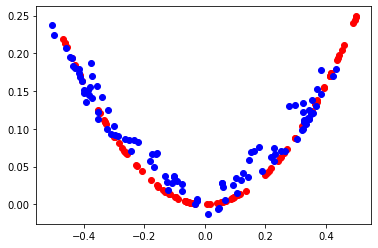

5399 0.3199999928474426 0.8100000023841858


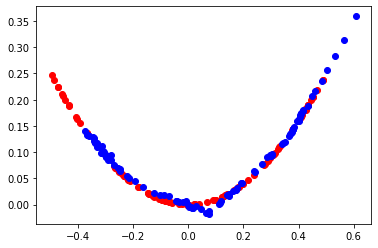

5599 0.7799999713897705 0.47999998927116394


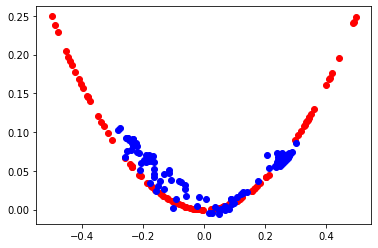

5799 0.2199999988079071 0.8100000023841858


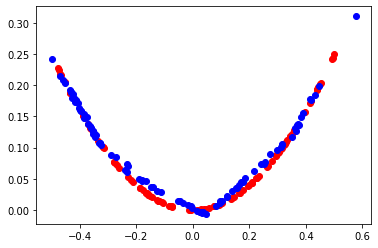

5999 0.3400000035762787 0.800000011920929


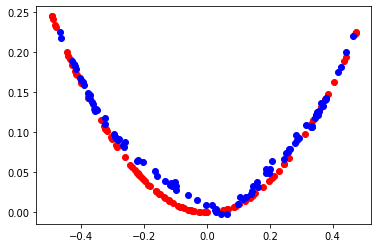

6199 0.5600000023841858 0.33000001311302185


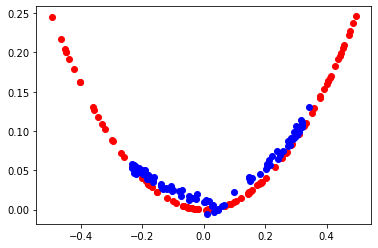

6399 0.6700000166893005 0.5


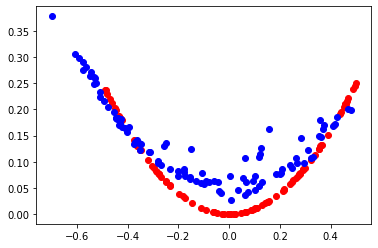

6599 0.4399999976158142 0.7799999713897705


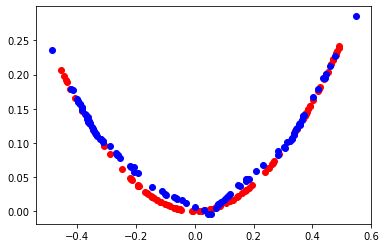

6799 0.2800000011920929 0.9300000071525574


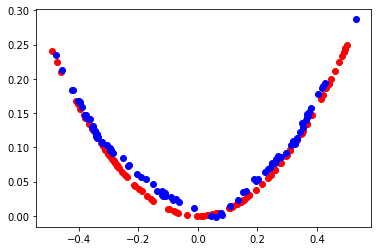

6999 0.2800000011920929 0.7799999713897705


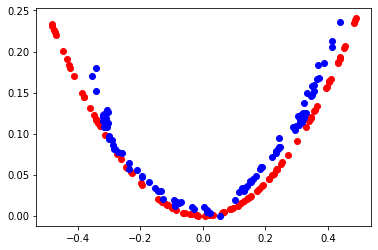

7199 0.4300000071525574 0.75


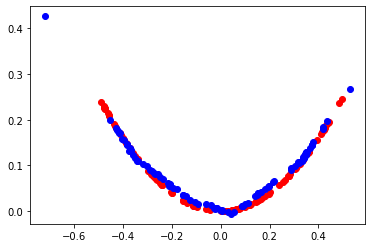

7399 0.550000011920929 0.6600000262260437


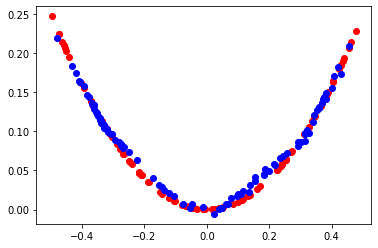

7599 0.699999988079071 0.36000001430511475


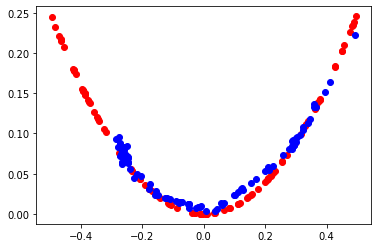

7799 0.4099999964237213 0.7300000190734863


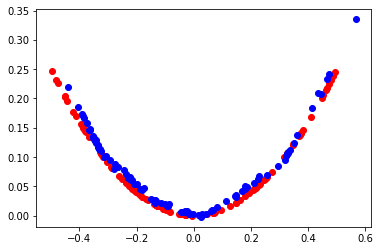

7999 0.5600000023841858 0.6800000071525574


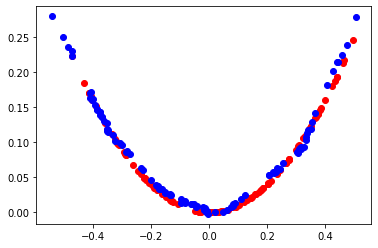

8199 0.5299999713897705 0.6700000166893005


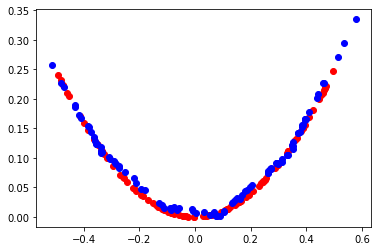

8399 0.6100000143051147 0.5699999928474426


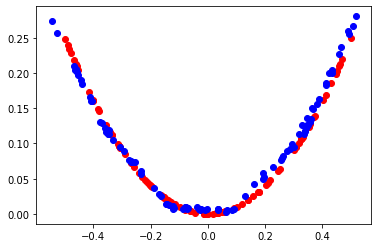

8599 0.6000000238418579 0.5199999809265137


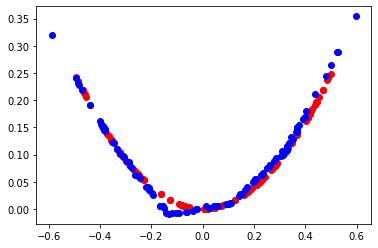

8799 0.6399999856948853 0.38999998569488525


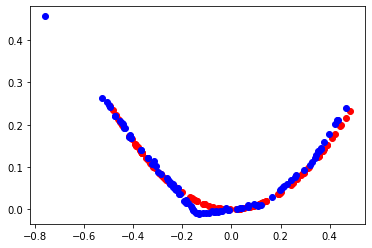

8999 0.5400000214576721 0.3799999952316284


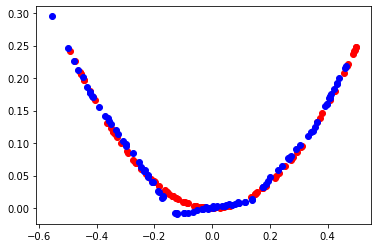

9199 0.6100000143051147 0.47999998927116394


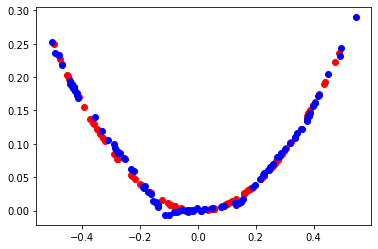

9399 0.6299999952316284 0.4000000059604645


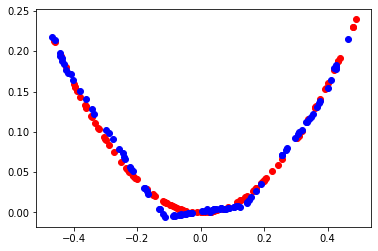

9599 0.5400000214576721 0.4399999976158142


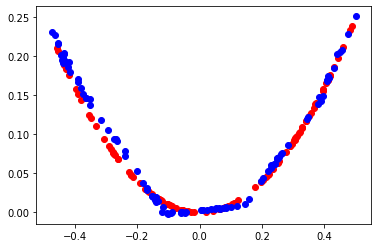

9799 0.4399999976158142 0.5699999928474426


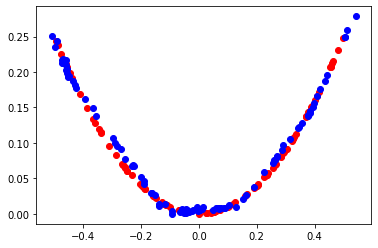

9999 0.4099999964237213 0.550000011920929


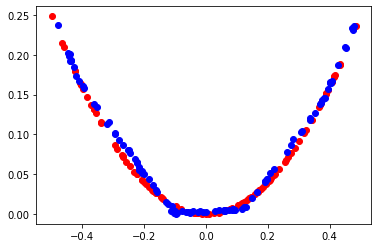

In [70]:

# size of the latent space
latent_dim = 6
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)